##Lab 2 - Linear regression

##The assignment

The context is “Predicting vibrational frequencies from the external chemical environment”. That is given a number descriptors, 
what can we infer about the frequency. Or in reverse, what information regarding the structure is hidden in the frequency.  You 
can use the proposed work-ﬂow below, or explore the data more freely. However, you should demonstrate the use of the 
techniques we have covered in the lecture/workshops. 

##Proposed  work-ﬂow: 

Load the csv-ﬁles with with frequencies and descriptors into a pandas data-frame.

NOTE: There is a reference bulk data-set for comparison alongside the surface data described above.

Perform a few ANOVA tests for all/selected descriptors in the surface and bulk data-set to get a feel for what correlation there are among the various descriptors.

Perform PCA or LDA analysis on the data. E.g. to compare if bulk and surface data can be discriminated.

Perform a number regressions and try to ﬁnd a model with a reduced number of independent variables that can make robust prediction of frequencies.

Make a correlation plot similar to that of Libowitzky (slide 8), but with surface and bulk data highlighted. Draw a ﬁtted model curve from e.g. i kernel ridge regression on top of the data.  

Summarise your ﬁndings into a reasonably comprehensive jupyter notebook. Write down some reﬂections and interesting ﬁndings from your “research”.


ANOVA:

Look if the variance between the descriptors are correlated or not 
Compare exp surface data with bulk data to see if there is a difference between the data sets. 

In [39]:
#Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as iter
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools as iter
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats

Masking in pandas df: 

first condition:
data_cured_step1 = data[data['Freq'] < 4000]
Second condition:
data_cured_step2 = data[data_cured_step1['rOO'] < 4.0]

eller & nästa argument

In [40]:
#Import data

#Experimental data
data = pd.read_csv('Suface_data.csv', sep=',')
data_df = pd.DataFrame(data)
#print(data_df)

#curing/removing unwanted parts of the data 
#data_df_cured_step1 = data_df[data_df['acceptor_type']!='NaN']
#print(data_df_cured_step1)

#Bulk data for reference
bulk_data_1 = pd.read_csv('bulk_data_1.csv', sep=',')
bulk_data_2 = pd.read_csv('bulk_data_2.csv', sep=',')
#print(bulk_data_1, bulk_data_2)


     Unnamed: 0  Frequency    EFddec      EFfc acceptor_type       Type  \
0             0   3577.868  0.000151  0.000402           NaN      water   
1             1   3577.868  0.000152  0.000405           NaN      water   
2             2   3511.409  0.015010  0.032563           H2O      water   
3             3   2952.498  0.053806  0.102202           O2-      water   
4             4   3514.452  0.039665  0.066010           OH-  hydroxide   
..          ...        ...       ...       ...           ...        ...   
212         212   2816.551  0.109617  0.163932           OH-  hydroxide   
213         213   2528.199  0.110814  0.174560           OH-  hydroxide   
214         214   3584.097  0.032979  0.060920           NaN  hydroxide   
215         215   3047.550  0.041758  0.062331           OH-      water   
216         216   2527.841  0.066925  0.115264           OH-      water   

          rHO       rOO        tOHO   sOHQM  OH_bond_order  
0    3.000000  3.500000  100.000000  0

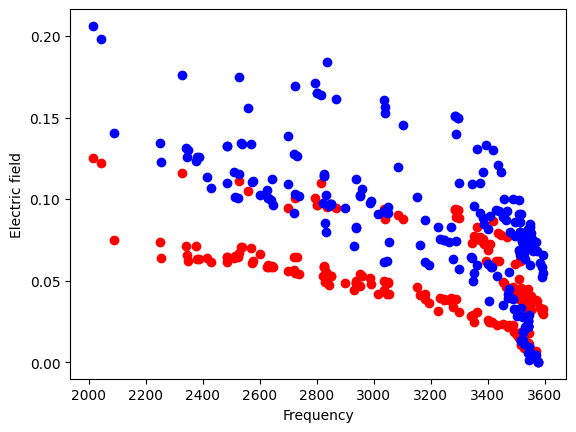

In [41]:
#Initial plotting of the data 
plt.xlabel("Frequency")
plt.ylabel("Electric field")
plt.scatter(data_df['Frequency'], data_df['EFddec'], color='red')
plt.scatter(data_df['Frequency'], data_df['EFfc'], color='blue')

In [42]:
#Do a statistical pairwise t-test on the two methods as independent values to calculate the electrical filed. 
#Null hypothesis is that they are the same. 
#By rejecting the null hypothesis, we show that the distributions are significally different. 

data_1 = data_df['EFddec']
data_2 = data_df['EFfc']

print("Mean value data_1: ",np.array(data_1).mean())
print("Mean value data_2: ",np.array(data_2).mean())
print("")
print("============================================================================================================")

# Perform the two independent samples t-test
t_test, p_value = stats.ttest_ind(data_1, data_2)

# Set significance level (α)
alpha = 0.05

# Compare the p-value with the significance level
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis.")

Mean value data_1:  0.049493325706268854
Mean value data_2:  0.08632454280608085

t-test: -11.11659656543604 --> p-value:  2.0246798930113616e-25  <  0.05
Reject the null hypothesis. The distributions are significantly different.


In [43]:
##Do a statistical pairwise t-test on the two methods as dependent values to calculate the electrical filed. 
#Null hypothesis is that they are the same. 

data_1 = data_df['EFddec']
data_2 = data_df['EFfc']

print("Mean value data_1: ",np.array(data_1).mean())
print("Mean value data_2: ",np.array(data_2).mean())
print("")
print("============================================================================================================")

# Perform relative two-samples t-test
t_test, p_value = stats.ttest_rel(data_1, data_2)

# Set significance level (α)
alpha = 0.05

# Compare the p-value with the significance level
if p_value < alpha:
    print("t-test:", t_test, "--> p-value: ",p_value," < ",alpha)
    print("Reject the null hypothesis. The distributions are significantly different.")
else:
    print("t-test:", t_test, "--> p-value: ",p_value," > ",alpha)
    print("Fail to reject the null hypothesis.")



Mean value data_1:  0.049493325706268854
Mean value data_2:  0.08632454280608085

t-test: -28.932813655794973 --> p-value:  3.002530573764127e-76  <  0.05
Reject the null hypothesis. The distributions are significantly different.


Both the t-test for the independent matching and the pair-wise test gives that the distributions are significantly different. 

No lets do a full ANOVA of the data set:

In [48]:
#one way ANOVA for all descriptors in the data to se if they correlate
#The null hypotesis is that they are the same. 

surface_freq = data_df['Frequency']
surface_EFddec = data_df['EFddec']
surface_EFfc = data_df['EFfc']
surface_rHO = data_df['rHO']
surface_rOO = data_df['rOO']
surface_tOHO = data_df['tOHO']
surface_sOHQM = data_df['sOHQM']
surface_OHBO = data_df['OH_bond_order']

F_test, p_value =stats.f_oneway(surface_freq, surface_EFddec, surface_EFfc, surface_rHO, surface_rOO, surface_tOHO, surface_sOHQM, surface_OHBO)

print("t-test: ",F_test," -> P-value: ",p_value)

t-test:  12860.886997900208  -> P-value:  0.0


p=0, we reject the null hypothesis that the distributions are the same. There is not a correlation between ALL of the descriptors. 

Now lets move on to try to compare the surface data to the bulk data given. 

In [47]:


print(data_df)
#print(bulk_data_1)

#Parameters that exist in surface and bulk data, do pairwise t-test on all five descriptors. 
#EFfc, rHO, rOO, tOHO, sOH

     Unnamed: 0  Frequency    EFddec      EFfc acceptor_type       Type  \
0             0   3577.868  0.000151  0.000402           NaN      water   
1             1   3577.868  0.000152  0.000405           NaN      water   
2             2   3511.409  0.015010  0.032563           H2O      water   
3             3   2952.498  0.053806  0.102202           O2-      water   
4             4   3514.452  0.039665  0.066010           OH-  hydroxide   
..          ...        ...       ...       ...           ...        ...   
212         212   2816.551  0.109617  0.163932           OH-  hydroxide   
213         213   2528.199  0.110814  0.174560           OH-  hydroxide   
214         214   3584.097  0.032979  0.060920           NaN  hydroxide   
215         215   3047.550  0.041758  0.062331           OH-      water   
216         216   2527.841  0.066925  0.115264           OH-      water   

          rHO       rOO        tOHO   sOHQM  OH_bond_order  
0    3.000000  3.500000  100.000000  0

NameError: name 'EFfc' is not defined